### Step 0 : Init RoboFeeder Env
This cell sets up the environment for the RoboFeeder simulation by importing necessary modules and configuring the Python path.

In [ ]:
import os 
dir = os.getcwd()
if 'examples' in dir:
    os.chdir(os.getcwd().split('examples')[0])
else:
    print("please set the working directory to the root of the gym4ReaL repository")

# check if the current working directory is the root of the gym4ReaL repository
os.getcwd()

### Step 1 : Import Required Modules
This cell imports the necessary modules and updates the system path to include the gym4ReaL repository. It also imports the robot simulator and matplotlib for visualization purposes.

In [ ]:
import sys
sys.path.append(os.getcwd())  # <-- path to the *parent* of gym4real

import os
import gymnasium as gym
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt

import gym4real.envs.robofeeder as rf
from gym4real.algorithms.robofeeder import baseline

In [ ]:
### Step 2 : Define Plotting Function
This cell defines the `plot_action` function, which visualizes the picking point (action) on the observation image. The function rescales the action coordinates to match the image size and displays the result using matplotlib.

In [2]:
def plot_action(current_obs,action):
    # evaluate picking point respect to the observation
    print("evaluate picking point respect to the observation")
    plt.imshow(current_obs[0],cmap=plt.cm.gray)

    #rescale the action to the image size, with aciion being in [-1,1]
    action[0] = (action[0] + 1) * 0.5 * current_obs[0].shape[1]
    action[1] = (action[1] + 1) * 0.5 * current_obs[0].shape[0]
    # add x-y coordinates of the action
    plt.scatter(action[0],action[1],marker='o',color='red',s=100)
    plt.show()


In [ ]:
### Step 3 : Load Pretrained Agent
This cell loads the pretrained PPO agent for the RoboFeeder environment using ONNX Runtime. It sets up the path to the pretrained model and initializes the inference session with available providers.

In [3]:
current_dir = os.path.dirname(rf.__file__)
# Load the object detection network
pretrained_ppo_dir = os.path.join(current_dir, "utils", "Pretrained/")

# Init the ONNX runtime session
providers = ['CUDAExecutionProvider','CPUExecutionProvider']
pretrained_agent = ort.InferenceSession(pretrained_ppo_dir + 'robofeeder-picking.onnx',providers=providers)
# baseline_agent = baseline.Baseline_picking()

/usr/local/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


### Step 4 : Test Simulator
import the simulator configuration file to pass the required parameters to run. 
Relevant parameters to adapt:

#### ObjectToPick
    NUMBER_OF_OBJECTS: 1           # (int) Number of objects to pick
    SHUFFLE_OBJECTS: True          # (bool) Shuffle object positions at reset
    OBJ_CORRECT_ORIENTATION: True  # (bool) Ensure objects have correct orientation

#### Simulator Setting
    IS_SIMULATION_REAL_TIME: False   # (bool) Run simulation in real time
    IS_SIMULATION_SHOWED: True       # (bool) Show simulation window
    IS_SIMULATION_RECORD: False      # (bool) Record simulation video
    RECORD_FOLDER : "." # (str) Folder to save recorded videos


In [ ]:
import shutil

# Copy the default configuration file to a new editable file
default_config_file = os.getcwd() + "/gym4real/envs/robofeeder/configuration.yaml"
config_file = os.getcwd() + "/examples/robofeeder/notebooks/configuration_editable.yaml"
shutil.copy(default_config_file, config_file)

### Step 3 : Initialize RoboFeeder Environment

This cell creates an instance of the RoboFeeder picking environment using the specified configuration file. The environment is initialized with the required settings for subsequent experiments and evaluations.


In [ ]:
env = gym.make('gym4real/robofeeder-picking-v0', config_file=config_file)

/usr/local/lib/python3.10/site-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment gym4real/robofeeder-picking-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
/usr/local/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


### Step 5 : Run Pretrained Agent and Visualize Action

This cell demonstrates how to use the pretrained PPO agent to interact with the RoboFeeder environment. The agent observes the environment, predicts an action, and executes it. The normalized action coordinates (X, Y, Theta) are printed, along with the reward and completion status. If the episode ends (`done` is True), the environment is reset for the next run.


In [ ]:
# perform an action with pretrained agent   
current_obs,_ = env.reset()
action = pretrained_agent.run(None, {"input": np.expand_dims(current_obs,axis=0)})[0][0]
print("pretrained agent action")
print("normalized X:",action[0]," normalized Y:",action[1]," Theta [rad]:",action[2])
obs,rew,done,_,_ = env.step(action)

print("done:",done) 
print("reward:",rew,"\n")

if(done): env.reset()

pretrained agent action
normalized X: 0.010316761  normalized Y: 0.77002335  Theta [rad]: -0.20724064
done: True
reward: -0.1372836790352628 



#### Result
The following code block demonstrates how to use the pretrained PPO agent to interact with the RoboFeeder environment. The agent receives an observation from the environment, predicts an action using the ONNX model, and executes this action in the environment. The normalized action coordinates (X, Y, Theta) are printed, along with the reward and completion status. If the episode ends (`done` is True), the environment is reset for the next run.


evaluate picking point respect to the observation


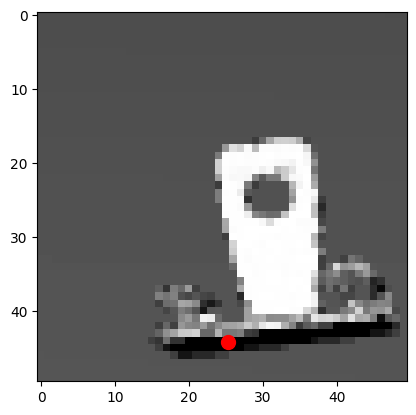

In [6]:
plot_action(current_obs,action)


### Step 6 : Run Baseline Agent and Visualize Action

This cell demonstrates how to use the baseline picking agent to interact with the RoboFeeder environment. The baseline agent generates an action based on the environment's action space, which is then executed in the environment. The normalized action coordinates (X, Y, Theta) are printed, along with the reward and completion status. If the episode ends (`done` is True), the environment is reset for the next run.


In [7]:
baseline_agent = baseline.Baseline_picking(env.action_space)

In [8]:
# perform an action with baseline agent   

current_obs,_ = env.reset()
action = baseline_agent.act()
print("pretrained agent action")
print("normalized X:",action[0]," normalized Y:",action[1]," Theta [rad]:",action[2])
action = np.array(action)
obs,rew,done,_,_ = env.step(action)

print("done:",done) 
print("reward:",rew,"\n")

if(done): env.reset()


pretrained agent action
normalized X: 0.0  normalized Y: 0.0  Theta [rad]: 0.0
done: True
reward: -0.764448816103563 



evaluate picking point respect to the observation


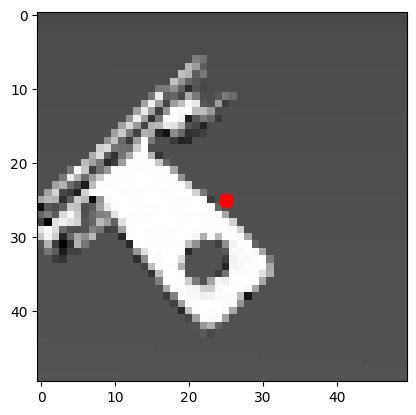

In [9]:
plot_action(current_obs,action)